In [1]:
import cv2
import pandas as pd
import numpy as np
import aeon.io.api as aeon
import matplotlib.pyplot as plt

from aeon.io import reader
from aeon.analysis.movies import gridframes
from aeon.analysis.utils import *
from aeon.schema.dataset import exp02
from aeon.io.video import frames, export

%matplotlib widget

In [2]:
rfid_data = {
    "0303": {
        "root": "/ceph/aeon/aeon/data/raw/AEON3/presocial0.1",
        "start": pd.Timestamp("2023-03-03 13:52:20.231999874"),
        "end": pd.Timestamp("2023-03-03 15:53:12.751999855"),
        "rfid_a": (928, 883),
        "rfid_b": (941, 875),
        "rfid_c": (936, 896),
        "rfid_d": (949, 888),
    },
    "0317": {
        "root": "/ceph/aeon/aeon/data/raw/AEON3/presocial0.1",
        "start": pd.Timestamp("2023-03-17 15:00:00"),
        "end": pd.Timestamp("2023-03-17 19:15:42.432000160"),
        "rfid_a": (920, 898),
        "rfid_b": (933, 890),
        "rfid_c": (928, 911),
        "rfid_d": (941, 903),
    },
}


def calc_dist(data_diff, x_label="x", y_label="y"):
    return np.linalg.norm(data_diff[[x_label, y_label]], axis=1)


def calc_velocity(data, x_label="x", y_label="y"):
    return calc_dist(data[[x_label, y_label]].diff(), x_label, y_label) / (
        data.index.to_series().diff().dt.total_seconds()
    )


def populate_session_data(session: dict):
    session["rfid_mid"] = (
        (session["rfid_c"][0] + session["rfid_b"][0]) / 2,
        (session["rfid_c"][1] + session["rfid_b"][1]) / 2,
    )
    session["rfid_radius"] = np.sqrt(
        (session["rfid_mid"][0] - session["rfid_a"][0]) ** 2
        + (session["rfid_mid"][1] - session["rfid_a"][1]) ** 2
    )
    bitmask = aeon.load(
        session["root"],
        reader.Harp(pattern="Rfid_32", columns=["Rfid"]),
        start=session["start"],
        end=session["end"],
    ).iloc[0, 0]
    session["rfid_enter"] = aeon.load(
        session["root"],
        reader.BitmaskEvent("Rfid_32", bitmask, "rfid_enter"),
        start=session["start"],
        end=session["end"],
    )
    session["rfid_exit"] = aeon.load(
        session["root"],
        reader.BitmaskEvent("Rfid_33", bitmask, "rfid_exit"),
        start=session["start"],
        end=session["end"],
    )
    session["p2_deliver"] = aeon.load(
        session["root"],
        reader.BitmaskEvent("Patch2_35", 0x1, "TriggeredPellet"),
        start=session["start"],
        end=session["end"],
    )
    session["p2_wheel"] = -1 * distancetravelled(
        aeon.load(
            session["root"],
            exp02.Patch2.Encoder,
            start=session["start"],
            end=session["end"],
        ).angle
    )
    session["pos"] = aeon.load(
        session["root"],
        exp02.CameraTop.Position,
        start=session["start"],
        end=session["end"],
    ).dropna()
    session["pos"]["rfid_dist"] = calc_dist(
        pd.concat(
            [
                session["pos"].x - session["rfid_mid"][0],
                session["pos"].y - session["rfid_mid"][1],
            ],
            axis=1,
        )
    )
    session["pos_enter"] = aeon.load(
        session["root"], exp02.CameraTop.Position, time=session["rfid_enter"].index
    ).dropna()
    session["pos_enter"]["rfid_dist"] = calc_dist(
        pd.concat(
            [
                session["pos_enter"].x - session["rfid_mid"][0],
                session["pos_enter"].y - session["rfid_mid"][1],
            ],
            axis=1,
        )
    )
    session["pos_exit"] = aeon.load(
        session["root"], exp02.CameraTop.Position, time=session["rfid_exit"].index
    ).dropna()
    session["pos_exit"]["rfid_dist"] = calc_dist(
        pd.concat(
            [
                session["pos_exit"].x - session["rfid_mid"][0],
                session["pos_exit"].y - session["rfid_mid"][1],
            ],
            axis=1,
        )
    )
    session["rfid_enter_exit"] = pd.DataFrame(
        {"enter": session["pos_enter"].index, "exit": session["pos_exit"].index}
    )
    return session


def assign_rfid_entry(pos, pos_enter, pos_exit, rfid_enter_exit):
    # get the nearest RFID enter time
    pos = pd.merge_asof(
        pos,
        pos_enter.index.to_series().rename_axis("idx").rename("enter"),
        right_on="enter",
        left_index=True,
        direction="nearest",
    )
    # get the nearest RFID exit time
    pos = pd.merge_asof(
        pos,
        pos_exit.index.to_series().rename_axis("idx").rename("exit"),
        right_on="exit",
        left_index=True,
        direction="nearest",
    )
    mask = pos.isna().any(axis=1)
    pos.loc[~mask, "enter"] = pos.loc[~mask].apply(
        lambda row: rfid_enter_exit.loc[
            rfid_enter_exit.enter == row.enter, "enter"
        ].iloc[0]
        if abs(row.name - row["enter"]) < abs(row.name - row["exit"])
        else rfid_enter_exit.loc[rfid_enter_exit.exit == row.exit, "enter"].iloc[0],
        axis=1,
    )
    pos = pos.drop(columns=["exit"])
    pos = pos.reset_index().merge(rfid_enter_exit, on="enter").set_index("time")
    return pos


In [3]:
rfid_data["0317"] = populate_session_data(rfid_data["0317"])
# rfid_data["0303"] = populate_session_data(rfid_data["0303"])


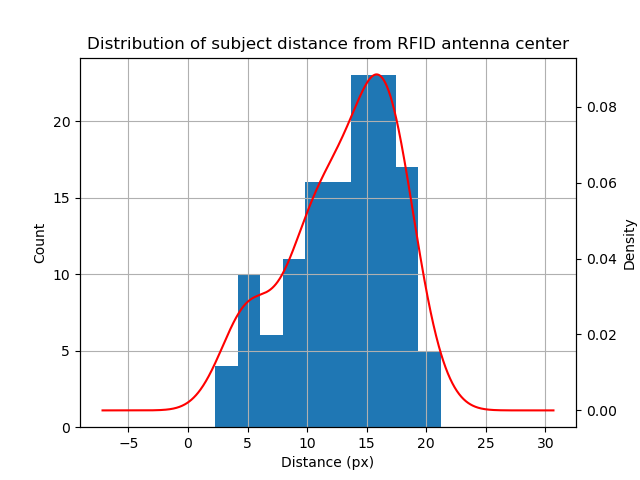

In [4]:
# distribution of subject distance from RFID antenna center
fig, ax = plt.subplots()
ax2 = ax.twinx()
rfid_data["0317"]["pos_enter"]["rfid_dist"].hist(bins=10, ax=ax)
rfid_data["0317"]["pos_enter"]["rfid_dist"].plot(kind="kde", ax=ax2, color="r")
ax.set_xlabel("Distance (px)")
ax.set_ylabel("Count")
ax2.set_ylabel("Density")
ax.set_title("Distribution of subject distance from RFID antenna center")
plt.show()

In [5]:
pos = rfid_data["0317"]["pos"]
# associate each position with the closest RFID enter/exit time
pos = assign_rfid_entry(
    pos,
    rfid_data["0317"]["pos_enter"],
    rfid_data["0317"]["pos_exit"],
    rfid_data["0317"]["rfid_enter_exit"],
)


In [6]:
# RFID antenna min detection distance
pos_near_rfid_min = pos[
    pos["rfid_dist"] <= rfid_data["0317"]["pos_enter"]["rfid_dist"].min()
]
pos_far_rfid_min = pos[
    ~(pos["rfid_dist"] <= rfid_data["0317"]["pos_enter"]["rfid_dist"].min())
]

# tp_min: when subject is within RFID min detection distance and time is within RFID enter/exit time (accurate detection), subset of tp_max
tp_min = pos_near_rfid_min[
    (pos_near_rfid_min.index >= pos_near_rfid_min["enter"])
    & (pos_near_rfid_min.index <= pos_near_rfid_min["exit"])
]

# fn_min: when subject is within RFID min detection distance and time is not within RFID enter/exit time (time to detection), subset of fn_max
fn_min = (
    pd.merge(
        pos_near_rfid_min,
        pd.DataFrame(index=tp_min.index, data=[0] * len(tp_min)),
        left_index=True,
        right_index=True,
        indicator=True,
        how="outer",
    )
    .query('_merge=="left_only"')
    .drop(["_merge", 0], axis=1)
)
fn_min["diff"] = (
    fn_min.reset_index().groupby("enter")["time"].diff().set_axis(fn_min.index)
)

# fp_min: when subject is not within RFID min detection distance and time is within RFID enter/exit time
# (does not make sense as can coincide with tp_max)
fp_min = pos_far_rfid_min[
    (pos_far_rfid_min.index >= pos_far_rfid_min["enter"])
    & (pos_far_rfid_min.index <= pos_far_rfid_min["exit"])
]

# tn_min: when subject is not within RFID min detection distance and time is not within RFID enter/exit time
# (does not make sense as can coincide with fn_max)
tn_min = (
    pd.merge(
        pos_far_rfid_min,
        pd.DataFrame(index=fp_min.index, data=[0] * len(fp_min)),
        left_index=True,
        right_index=True,
        indicator=True,
        how="outer",
    )
    .query('_merge=="left_only"')
    .drop(["_merge", 0], axis=1)
)

# RFID antenna max detection distance
pos_near_rfid_max = pos[
    pos["rfid_dist"] <= rfid_data["0317"]["pos_enter"]["rfid_dist"].max()
]
pos_far_rfid_max = pos[
    ~(pos["rfid_dist"] <= rfid_data["0317"]["pos_enter"]["rfid_dist"].max())
]

# tp_max: when subject is within RFID max detection distance and time is within RFID enter/exit time (accurate detection)
tp_max = pos_near_rfid_max[
    (pos_near_rfid_max.index >= pos_near_rfid_max["enter"])
    & (pos_near_rfid_max.index <= pos_near_rfid_max["exit"])
]

# fn_max: when subject is within RFID max detection distance and time is not within RFID enter/exit time
fn_max = (
    pd.merge(
        pos_near_rfid_max,
        pd.DataFrame(index=tp_max.index, data=[0] * len(tp_max)),
        left_index=True,
        right_index=True,
        indicator=True,
        how="outer",
    )
    .query('_merge=="left_only"')
    .drop(["_merge", 0], axis=1)
)
# filter out non-continuous rows and select the first n continuous rows preceding detection
fn_max["diff"] = (
    fn_max.reset_index().groupby("enter")["time"].diff().set_axis(fn_max.index)
)
fn_max.loc[fn_max["diff"] > pd.Timedelta("25ms"), "diff"] = pd.NaT
fn_max_enter = fn_max[fn_max["enter"] > fn_max.index]
fn_max_enter = (
    fn_max_enter[fn_max_enter["diff"].isna()]
    .loc[::-1]
    .reset_index()
    .groupby(["enter"])
    .nth(0)
    .reset_index()
    .set_index("time")
)

# fp_max: when subject is not within RFID max detection distance and time is within RFID enter/exit time
fp_max = pos_far_rfid_max[
    (pos_far_rfid_max.index >= pos_far_rfid_max["enter"])
    & (pos_far_rfid_max.index <= pos_far_rfid_max["exit"])
]
# calculate average speed for each entry
fp_max = fp_max.merge(
    fp_max.groupby("enter")
    .apply(calc_velocity)
    .groupby("enter")
    .mean()
    .rename("avg_velocity"),
    how="left",
    left_on="enter",
    right_index=True,
)

# tn_max: when subject is not within RFID max detection distance and time is not within RFID enter/exit time
tn_max = (
    pd.merge(
        pos_far_rfid_max,
        pd.DataFrame(index=fp_max.index, data=[0] * len(fp_max)),
        left_index=True,
        right_index=True,
        indicator=True,
        how="outer",
    )
    .query('_merge=="left_only"')
    .drop(["_merge", 0], axis=1)
)


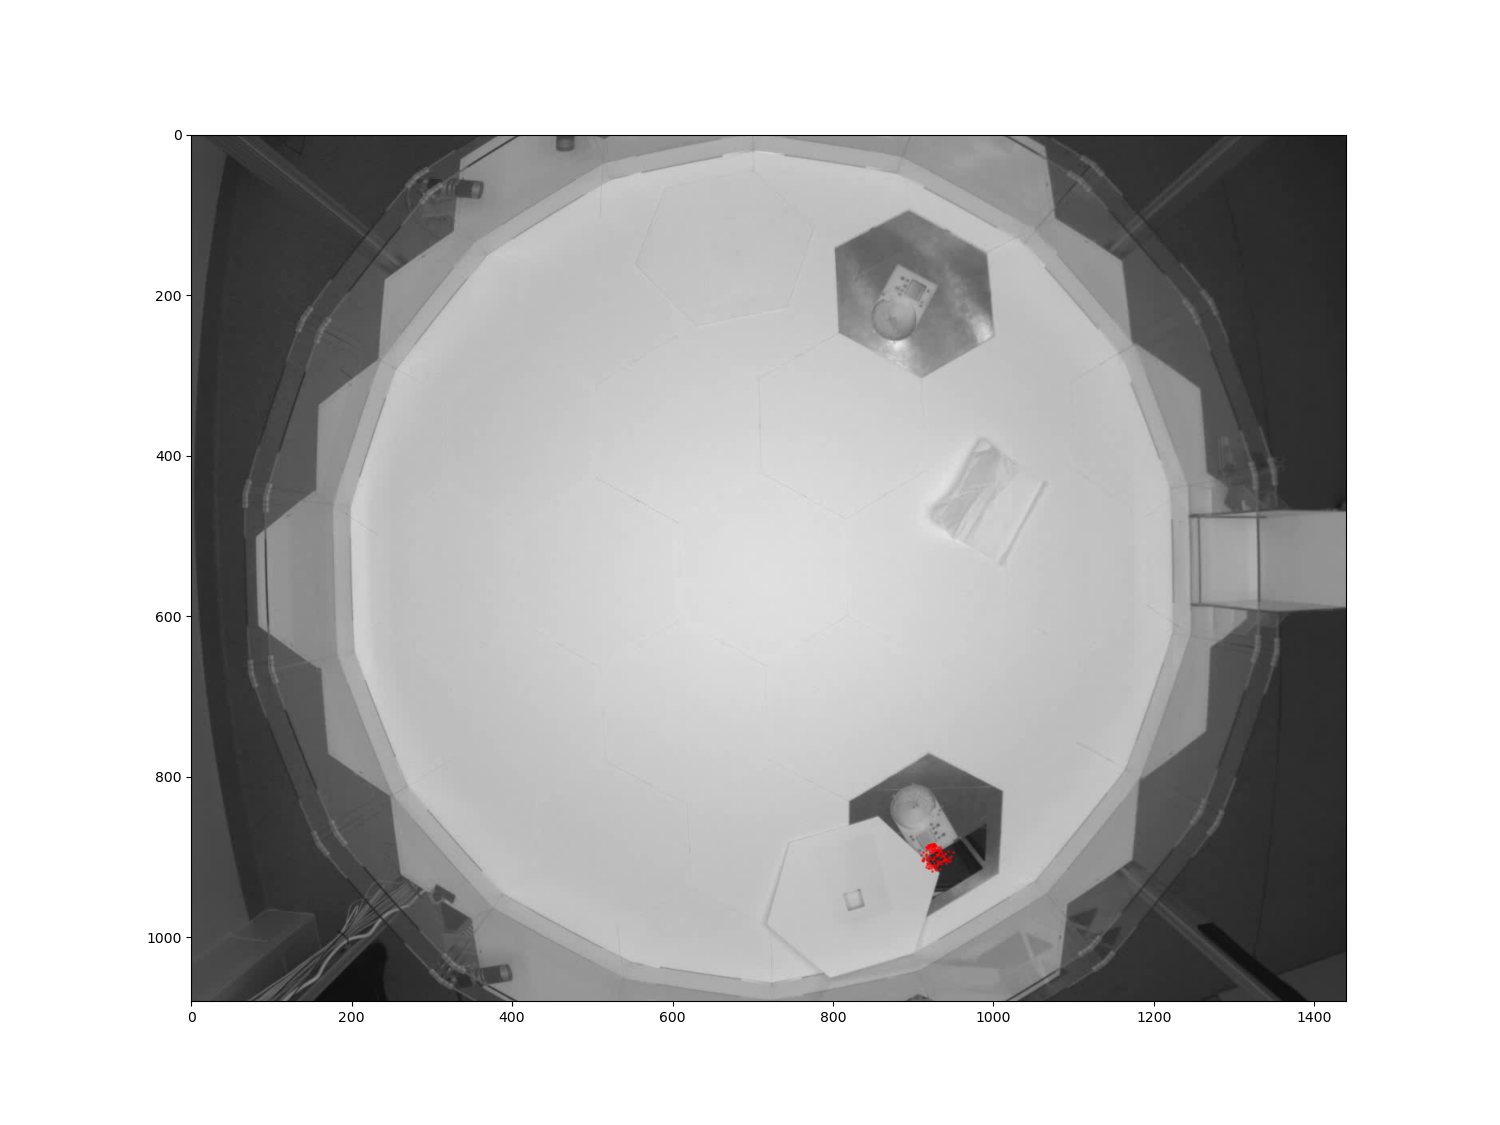

In [7]:
# plot RFID enter pos
fig, ax = plt.subplots(figsize=(1440 / 96, 1080 / 96))
im = ax.imshow(plt.imread("aeon3_230315.png"), extent=[0, 1440, 1080, 0])
ax.scatter(
    rfid_data["0317"]["pos_enter"]["x"],
    rfid_data["0317"]["pos_enter"]["y"],
    s=1,
    c="r",
    alpha=0.5,
)
# plt.savefig("rfidreads_overlay.png", dpi=96)
plt.show()

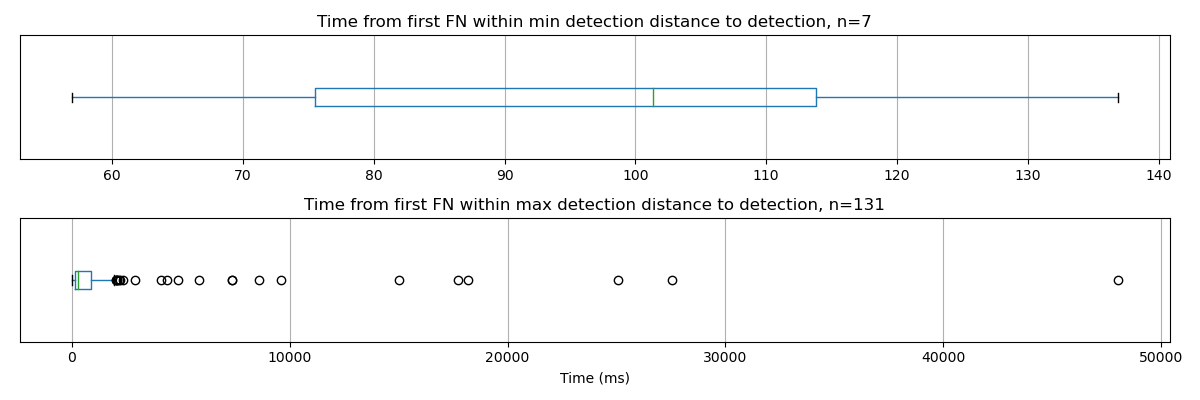

In [8]:
# calc time elapsed from the first timestamp when the subject is within the RFID (min/max) detection distance until detection
time_to_detection_max = pd.DataFrame(
    (
        fn_max_enter["enter"].unique()
        - fn_max_enter.reset_index().groupby(["enter"])["time"].min()
    ).dt.total_seconds()
    * 1000
)
time_to_detection_min = pd.DataFrame(
    (
        fn_min["enter"].unique() - fn_min.reset_index().groupby(["enter"])["time"].min()
    ).dt.total_seconds()
    * 1000
)
time_to_detection_max["group"] = (time_to_detection_max.time / 1000).astype(
    int
) * 1000  # floor to nearest 1000

fig, ax = plt.subplots(2, 1, figsize=(12, 4))
time_to_detection_min.boxplot(ax=ax[0], vert=False)
time_to_detection_max.boxplot("time", ax=ax[1], vert=False)
ax[0].set_yticks([])
ax[1].set_yticks([])
# ax[0].set_ylabel("min")
# ax[1].set_ylabel("max")
ax[1].set_xlabel("Time (ms)")
ax[0].set_title(
    "Time from first FN within min detection distance to detection, n="
    + str(len(time_to_detection_min))
)
ax[1].set_title(
    "Time from first FN within max detection distance to detection, n="
    + str(len(time_to_detection_max))
)
# fig.suptitle("Distribution of time to detection")
plt.tight_layout()
plt.show()


In [9]:
time_to_detection_max.groupby("group").describe()

time                                                        \
       count          mean         std           min           25%   
group                                                                
0      101.0    289.299327  232.268131     13.120174    133.471966   
1000     8.0   1442.276060  374.179173   1013.632297   1160.696149   
2000     8.0   2227.204084  296.130550   2031.551838   2048.808098   
4000     3.0   4442.560037  389.999384   4100.831986   4230.128050   
5000     1.0   5836.512089         NaN   5836.512089   5836.512089   
7000     2.0   7353.424072    7.625546   7348.031997   7350.728035   
8000     1.0   8596.960067         NaN   8596.960067   8596.960067   
9000     1.0   9585.952282         NaN   9585.952282   9585.952282   
15000    1.0  15005.504132         NaN  15005.504132  15005.504132   
17000    1.0  17718.815803         NaN  17718.815803  17718.815803   
18000    1.0  18176.735878         NaN  18176.735878  18176.735878   
25000    1.0  25048.928261         NaN  25048.928261  25048.928261   
27000    1.0  27540.192127         NaN  27540.192127  27540.192127   
47000    1.0  47999.040127         NaN  47999.040127  47999.040127   

                                                 
                50%           75%           max  
group                                            
0        229.375839    336.927891    937.567711  
1000    1352.479935   1809.688091   1938.911914  
2000    2118.496179   2248.328090   2911.648274  
4000    4359.424114   4613.424063   4867.424011  
5000    5836.512089   5836.512089   5836.512089  
7000    7353.424072   7356.120110   7358.816147  
8000    8596.960067   8596.960067   8596.960067  
9000    9585.952282   9585.952282   9585.952282  
15000  15005.504132  15005.504132  15005.504132  
17000  17718.815803  17718.815803  17718.815803  
18000  18176.735878  18176.735878  18176.735878  
25000  25048.928261  25048.928261  25048.928261  
27000  27540.192127  27540.192127  27540.192127  
47000  47999.040127  47999.040127  47999.040127

In [10]:
displacement_df = (
    fn_max.join(
        fn_max_enter.reset_index()
        .groupby(["enter"])["time"]
        .min()
        .rename("first_approach"),
        on="enter",
    )
    .join(time_to_detection_max, on="enter")
    .rename(columns={"time": "time_to_detection"})
)
displacement_df = displacement_df[
    (displacement_df.index >= displacement_df.first_approach)
    & (displacement_df.index <= displacement_df.enter)
]
displacement_df = displacement_df.merge(
    displacement_df.groupby("enter")
    .apply(calc_velocity)
    .groupby("enter")
    .mean()
    .rename("avg_velocity"),
    how="left",
    left_on="enter",
    right_index=True,
)

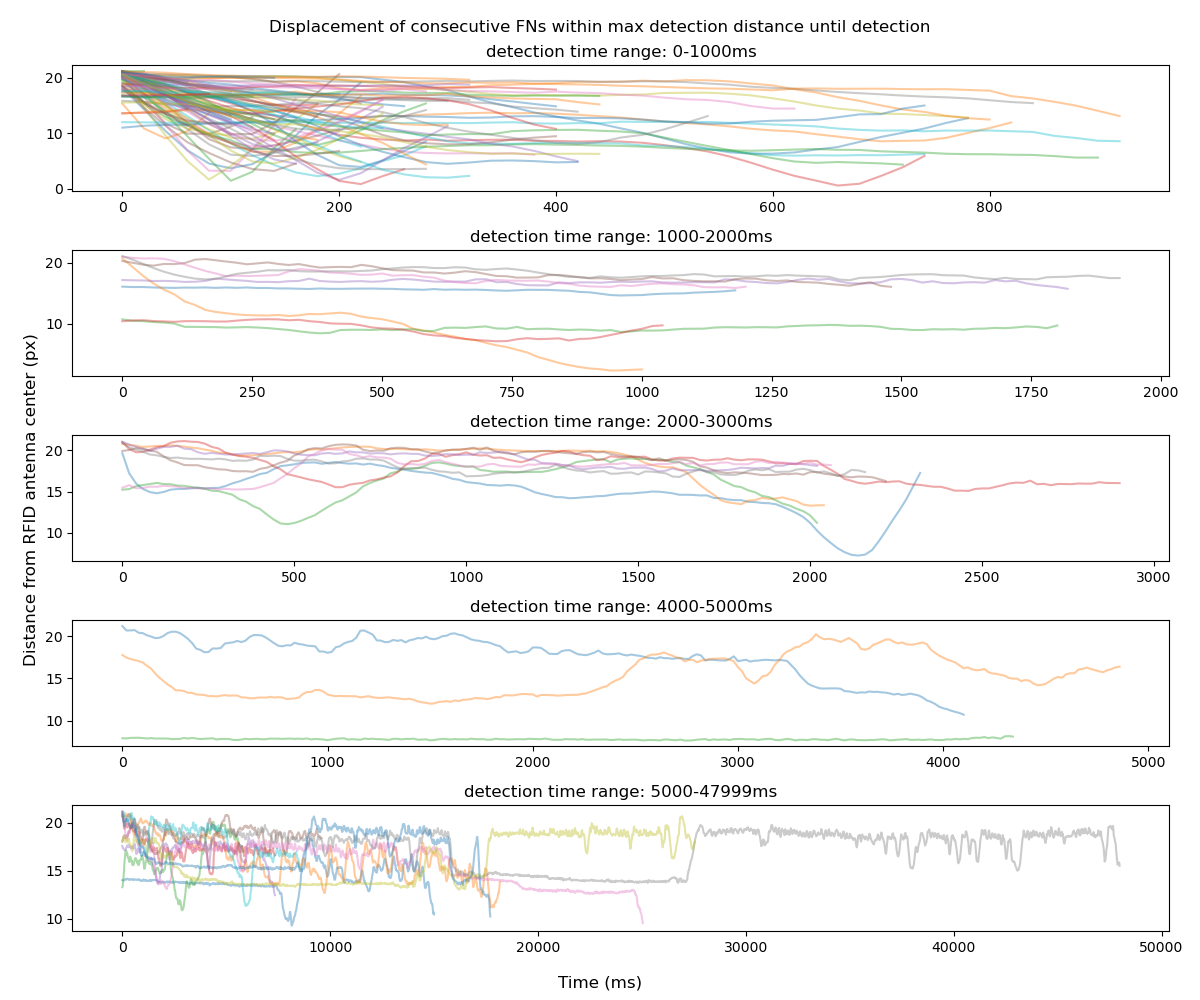

In [11]:
# plot displacement of consecutive FNs within max detection distance until detection
fig, ax = plt.subplots(5, 1, figsize=(12, 10))
for i, group in enumerate(np.sort(displacement_df.group.unique())[:5]):
    entries = (
        displacement_df[displacement_df.group == group].groupby("enter")
        if i < 4
        else displacement_df[displacement_df.group >= group].groupby("enter")
    )
    for name, entry in entries:
        ax[i].plot(
            range(0, len(entry) * 20, 20),
            entry.rfid_dist,
            marker="o",
            linestyle="solid",
            ms=0,
            label=name,
            alpha=0.4,
        )
        end_range = (
            group + 1000 if i < 4 else int(displacement_df.time_to_detection.max())
        )
        ax[i].set_title(f"detection time range: {group}-{end_range}ms")
fig.supxlabel("Time (ms)")
fig.supylabel("Distance from RFID antenna center (px)")
fig.suptitle(
    "Displacement of consecutive FNs within max detection distance until detection"
)
plt.tight_layout()
plt.show()


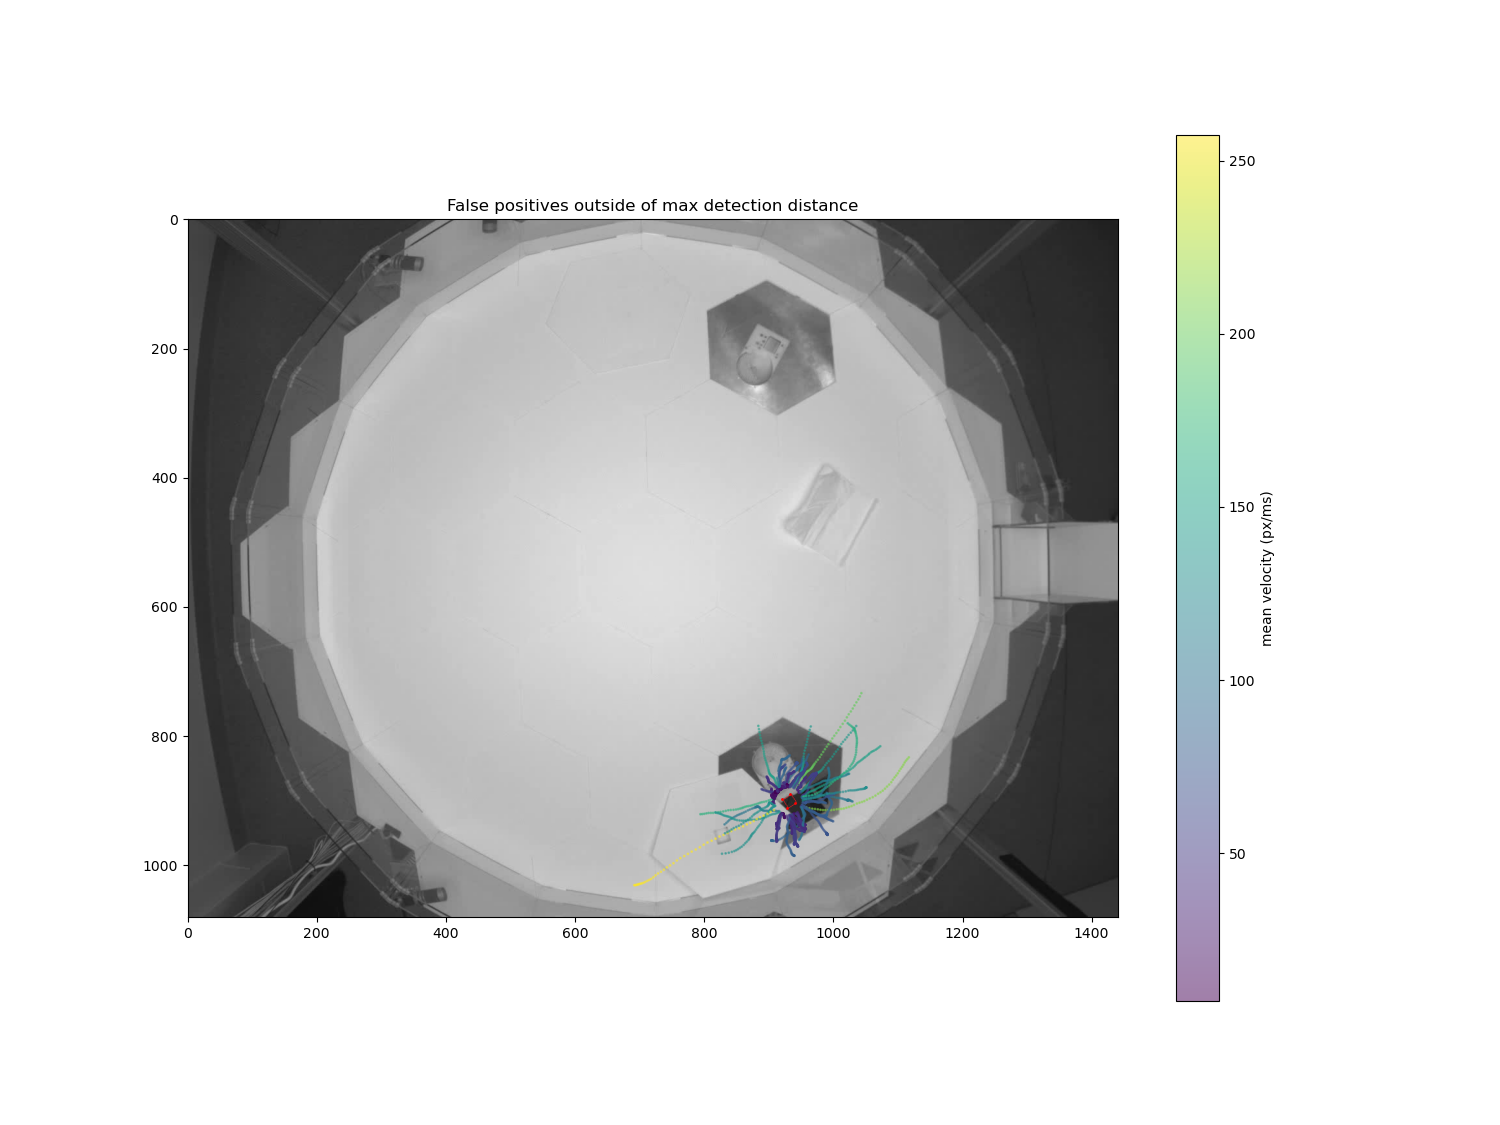

In [12]:
def plot_pos_overlay(pos, img, rfid_coords=None):
    fig, ax = plt.subplots(figsize=(1440 / 96, 1080 / 96))
    im = ax.imshow(plt.imread(img), extent=[0, 1440, 1080, 0])
    points = ax.scatter(pos.x, pos.y, alpha=0.5, s=1, c=pos.avg_velocity)
    if rfid_coords:
        ax.scatter([x[0] for x in rfid_coords], [y[1] for y in rfid_coords], s=1, c="r")
    cbar = fig.colorbar(points)
    cbar.set_label("mean velocity (px/ms)")
    ax.set_title("False positives outside of max detection distance")
    plt.show()


plot_pos_overlay(
    fp_max,
    "aeon3_230315.png",
    [
        rfid_data["0317"]["rfid_a"],
        rfid_data["0317"]["rfid_b"],
        rfid_data["0317"]["rfid_c"],
        rfid_data["0317"]["rfid_d"],
    ],
)


Text(0.5, 0.98, 'FP Paths')

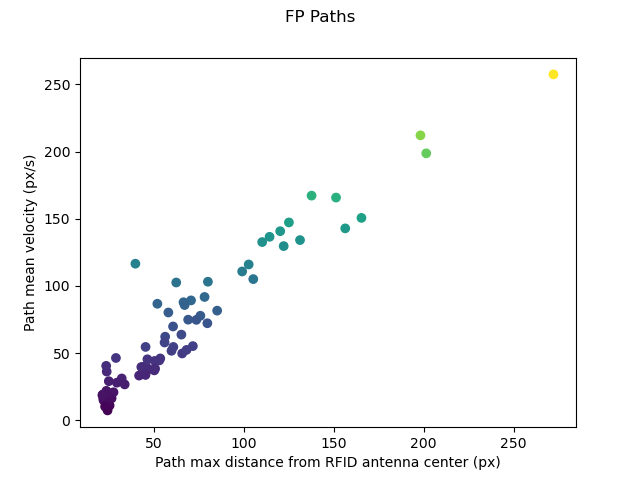

In [13]:
# correlation between mean velocity and max distance from RFID antenna center
fig, ax = plt.subplots()
ax.scatter(
    fp_max.groupby("enter")["rfid_dist"].max(),
    fp_max.groupby(["enter"])["avg_velocity"].first(),
    c=fp_max.groupby(["enter"])["avg_velocity"].first(),
)
ax.set_xlabel("Path max distance from RFID antenna center (px)")
ax.set_ylabel("Path mean velocity (px/s)")
fig.suptitle("FP Paths")


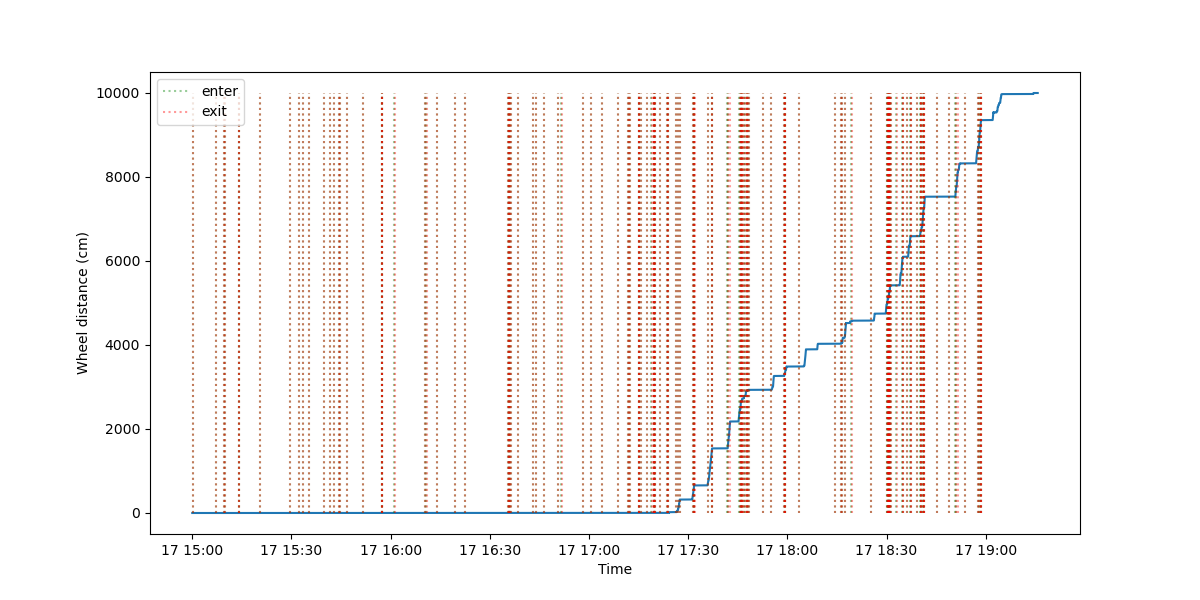

In [14]:
# plot wheel dist and rfid enter exit
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(rfid_data["0317"]["p2_wheel"])
ax.set_ylabel("Wheel distance (cm)")
ax.set_xlabel("Time")
ax.vlines(
    ymin=0,
    ymax=rfid_data["0317"]["p2_wheel"].max(),
    x=rfid_data["0317"]["pos_enter"].index,
    color="g",
    linestyle="dotted",
    alpha=0.4,
    label="enter",
)
ax.vlines(
    ymin=0,
    ymax=rfid_data["0317"]["p2_wheel"].max(),
    x=rfid_data["0317"]["pos_exit"].index,
    color="r",
    linestyle="dotted",
    alpha=0.4,
    label="exit",
)
ax.legend()
plt.show()

In [15]:
# RFID detection period stats
rfid_data["0317"]["rfid_enter_exit"].diff(axis=1).describe()


,enter,exit
count,0,131
mean,NaT,0 days 00:00:02.734446882
std,NaT,0 days 00:00:04.853881374
min,NaT,0 days 00:00:00.998847960
25%,NaT,0 days 00:00:00.998864174
50%,NaT,0 days 00:00:01.162367821
75%,NaT,0 days 00:00:02.257888317
max,NaT,0 days 00:00:31.731008053


In [23]:
# fraction of pellets within detection period
p2_deliver = pd.merge_asof(
    rfid_data["0317"]["p2_deliver"],
    rfid_data["0317"]["rfid_enter_exit"],
    right_on="enter",
    left_index=True,
    direction="backward",
)
len(
    p2_deliver[
        (p2_deliver.index >= p2_deliver.enter) & (p2_deliver.index <= p2_deliver.exit)
    ]
) / len(p2_deliver)

0.23711340206185566